In [1]:
#.Packages
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate
import fathon
from fathon import fathonUtils as fu
plt.style.use(['science','notebook'])

In [2]:
#.Data reading
url_darwin = 'https://crudata.uea.ac.uk/cru/data/soi/soi_dar.dat'
url_tahiti = 'https://crudata.uea.ac.uk/cru/data/soi/soi_tah.dat'
url_soi = 'https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat'
urls = [url_darwin, url_tahiti, url_soi]

p_darwin = './data/soi_dar.dat'
p_tahiti = './data/soi_tah.dat'
p_soi = './data/soi_3dp.dat'
p_bei = './data/BEI.dat'

paths = [p_darwin, p_tahiti, p_soi, p_bei]
df = []
for i in range(4):
    p = paths[i]
    if path.exists(p):
        df.append(pd.read_table(paths[i], header=None, delim_whitespace=True))
    else:
        f.append(pd.read_table(urls[i], header=None, delim_whitespace=True))
        print("None")
darwin = df[0]
tahiti = df[1]
soi = df[2]
bei = df[3]

In [3]:
#.Data tidying

#.Rename columns
darwin.rename(columns={0: 'Year'},inplace=True)
tahiti.rename(columns={0: 'Year'},inplace=True)
soi.rename(columns={0: 'Year', 13:'Annual'},inplace=True)
bei.rename(columns={0: 'Year'},inplace=True)

#.Write nan values
darwin[darwin==-990]=np.nan
tahiti[tahiti==-990]=np.nan
soi[soi==99.990]=np.nan
soi[soi==-99.990]=np.nan
bei.rename(columns={0: 'Year'},inplace=True)

#.Pivot data
darwin = darwin.reset_index()
da=pd.melt(darwin, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

tahiti = tahiti.reset_index()
ta=pd.melt(tahiti, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

soi = soi.reset_index()
so=pd.melt(soi, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12,'Annual'],var_name='Month',value_name='Pressure')

bei = bei.reset_index()
be=pd.melt(bei, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

#.Drop nan values
so.dropna()
ta.dropna()
da.dropna()
be.dropna()

#Join all data
historical = da.merge(ta, how='inner', on=['Year','Month'])  #Add tahiti to darwin measurements
historical = historical.merge(so, how='inner', on=['Year','Month'])  #Add SOI index
historical = historical.rename(columns={'Pressure_x':'Darwin','Pressure_y':'Tahiti','Pressure':'SOI'}) 
#.Divide by 10 some measurements
historical['Darwin'] = historical['Darwin'] / 10
historical['Tahiti'] = historical['Tahiti'] / 10
historical.dropna()
historical.sort_values(by=['Year','Month'],inplace=True)
#.Dataframe with dates (without days)
dates = pd.to_datetime(historical['Month'].astype(str)+'/'+historical['Year'].astype(str)).dt.date.apply(lambda x: x.strftime('%Y-%m'))
darwin = historical['Darwin']
tahity = historical['Tahiti']
soi = historical['SOI']
year = historical['Year']
bei = be['Pressure']
year_2 = be['Year']

## DCCA analysis

In [66]:
a = fu.toAggregated(darwin)
b = fu.toAggregated(tahity)
c = fu.toAggregated(soi)
pydcca = fathon.DCCA(a, b)

In [67]:
start = 5
stop = len(a)/4
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
n, F = pydcca.computeFlucVec(winSizes, polOrd=1)
H, H_intercept = pydcca.fitFlucVec()

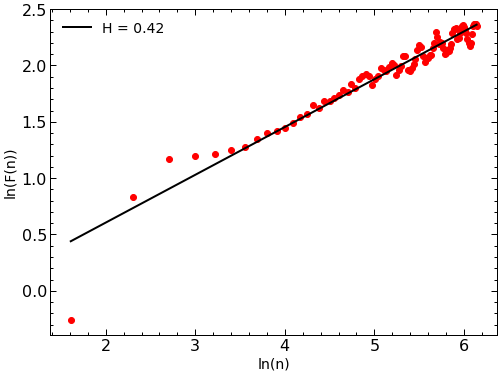

In [68]:
plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), 'k-', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
#plt.title('DCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

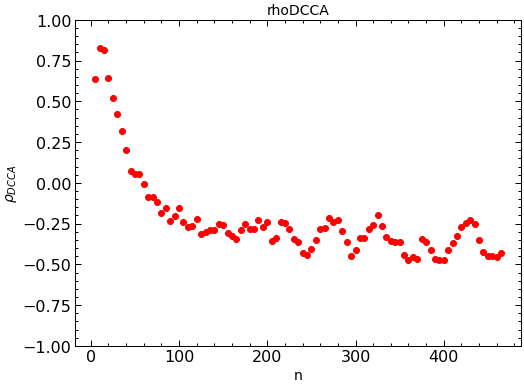

In [69]:
n, rho = pydcca.computeRho(winSizes, polOrd=polOrd)

plt.plot(n, rho, 'ro')
plt.ylim(-1, 1)
plt.xlabel('n', fontsize=14)
plt.ylabel('$\\rho_{DCCA}$', fontsize=14)
plt.title('rhoDCCA', fontsize=14)
plt.show()

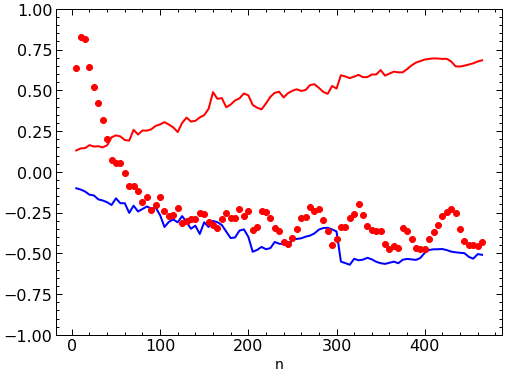

In [70]:
pythresh = fathon.DCCA()

L = 600

nSim = 100
confLvl = 0.95
polOrd = 1
n, cInt1, cInt2 = pythresh.rhoThresholds(L, winSizes, nSim, confLvl, polOrd=polOrd, verbose=False)

plt.plot(n, cInt1, 'r-')
plt.plot(n, cInt2, 'b-')
plt.plot(n, rho, 'ro')
plt.ylim(-1, 1)
plt.xlabel('n', fontsize=14)
plt.show()

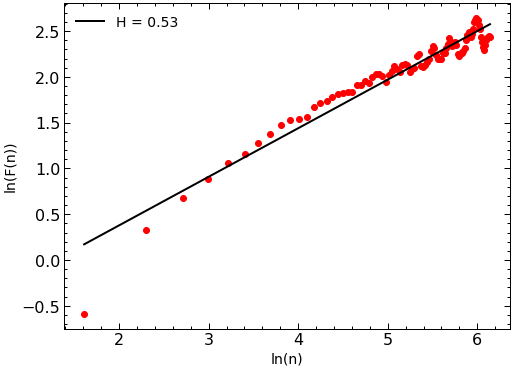

In [71]:
pydcca = fathon.DCCA(a, c)
start = 5
stop = len(a)/4
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
n, F = pydcca.computeFlucVec(winSizes, polOrd=1)
H, H_intercept = pydcca.fitFlucVec()

plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), 'k-', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
#plt.title('DCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

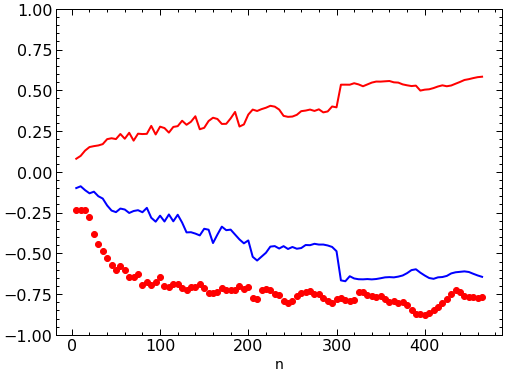

In [73]:
n, rho = pydcca.computeRho(winSizes, polOrd=polOrd)
pythresh = fathon.DCCA()

L = 600

nSim = 100
confLvl = 0.95
polOrd = 1
n, cInt1, cInt2 = pythresh.rhoThresholds(L, winSizes, nSim, confLvl, polOrd=polOrd, verbose=False)

plt.plot(n, cInt1, 'r-')
plt.plot(n, cInt2, 'b-')
plt.plot(n, rho, 'ro')
plt.ylim(-1, 1)
plt.xlabel('n', fontsize=14)
plt.show()

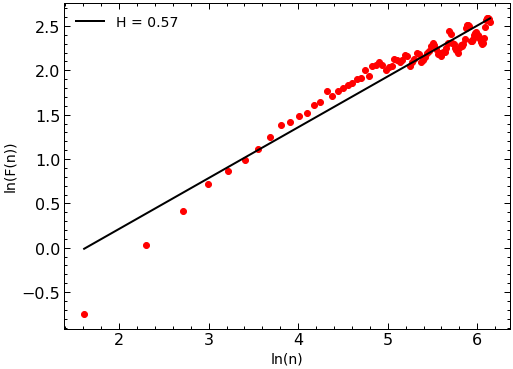

In [75]:
pydcca = fathon.DCCA(b, c)
start = 5
stop = len(a)/4
sStep = 5
winSizes = fu.linRangeByStep(start, stop, step=sStep)
polOrd = 1
n, F = pydcca.computeFlucVec(winSizes, polOrd=1)
H, H_intercept = pydcca.fitFlucVec()

plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), 'k-', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
#plt.title('DCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

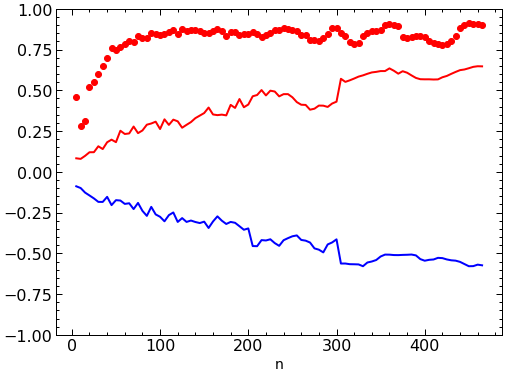

In [76]:
n, rho = pydcca.computeRho(winSizes, polOrd=polOrd)
pythresh = fathon.DCCA()

L = 600

nSim = 100
confLvl = 0.95
polOrd = 1
n, cInt1, cInt2 = pythresh.rhoThresholds(L, winSizes, nSim, confLvl, polOrd=polOrd, verbose=False)

plt.plot(n, cInt1, 'r-')
plt.plot(n, cInt2, 'b-')
plt.plot(n, rho, 'ro')
plt.ylim(-1, 1)
plt.xlabel('n', fontsize=14)
plt.show()